Import necessary modules

In [24]:
import json
import pandas as pd
import re
import random
from scipy import sparse
import numpy as np
from pymongo import MongoClient
from nltk.corpus import stopwords
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import TfidfVectorizer

from gensim import corpora, models, similarities, matutils
import tqdm
import sys
sys.path.append('/Users/ed/yelp-classification/machine_learning')
import yelp_ml_py3 as yml
#reload(yml)

Import necessary dictionaries and JSON files

In [2]:
lh_neg = open('../input/negative-words.txt', 'r', encoding = "ISO-8859-1").read()
lh_neg = lh_neg.split('\n')
lh_pos = open('../input/positive-words.txt', 'r', encoding = "ISO-8859-1").read()
lh_pos = lh_pos.split('\n')
users = json.load(open('../input/many_reviews_dictionary.json'))

word_list = list(set(lh_pos + lh_neg))

In [48]:
stop_words = set(stopwords.words('english')) 

In [3]:
import os
os.getcwd()

'/Users/ed/yelp-classification/machine_learning'

In [4]:
#Fix users JSON
users_dict = {}
user_ids = []

users_dict = {}
user_ids = []

for list in users['reviews']:
    users_dict[list[0]['user_id']]= list




for list_reviews in users['reviews']:
    user_ids.append(list_reviews[0]['user_id'])
    
#We have 228 users, creat a new dictionary where the user_ids are the keys and the entries are a list of reviews

    
with open('cleaned_large_user_dictionary.json', 'w') as outfile:
    json.dump(users_dict, outfile)

Try running a few tests on a subset of users, the keys are our unique user IDs. We proceed as follows for each user ID:


1. Create a review dataframe for ten thousand reviews with the following columns:
    * (review id,businessid,userid, review_text, number of cool, number of useful, number of cool + useful rating, number of friends that user has, date of review)
    
2. Do descriptive analysis to look how likes are distributed

3. Use scikitlearn to build a model to categorize more than x likes

4. do a test of the model over the test set.




In [62]:
conn = MongoClient()
conn.database_names()
db = conn.get_database('mydb')
reviews = db.get_collection('reviews')

In [64]:
x =[]

count = 0

while (count < 10000):
    x.append(reviews.find()[count])
    count = count +1
   
        
    


In [73]:
x[3000]


{'_id': ObjectId('59544da0666418c09d35641e'),
 'business_id': 'Pj7itML6Wocbp4cLuUmBBg',
 'cool': 1,
 'date': '2016-05-18',
 'funny': 0,
 'review_id': 'tjNXsRW_-Y-6ifPDpX_kZg',
 'stars': 1,
 'text': "The therapist Cynthia Osburn violated my privacy and failed to keep our therapy sessions confidential and instead provided my ex-wife with private conversations I had with her.  This is a violation of my HIPAA rights and I have filed the appropriate complaints.  Sure hope the other therapists in this group are more professional and obey the laws and professional conduct standards that this therapist failed to.  I have requested my children's medical records numerous times now over the past 7 weeks and Ms. Osburn continues to not release them.  Thank goodness my children will begin seeing a new therapist soon.  Ms. Osburn is a new to the field of therapy and seems to have done more harm than good with my son.  She had him keep a journal of only negatives and he was not to write any positives

In [68]:
train_reviews =[]

reviews = []
stars = []
cool = []
useful = []
funny = []
compliment = []
cunumber = []

for review in x :
    train_reviews.append(review['text'])
    cool.append(review['cool'])
    useful.append(review['useful'])
    funny.append(review['funny'])
    compliment.append(review['funny']+review['useful']+review['cool'])
    cunumber.append(review['useful']+review['cool'])    

In [69]:
train_reviews[500]


'Mill Avenue is an interesting place.  It reminds of a downtown area, but smaller.  This place is popular because it is within walking distance to Arizona State University and has a ton of stores.  Many artists/performers like to come here and play their instruments on the streets on certain nights (I believe often on Thursday, Friday, and Saturdays).  There are so many different type of stores throughout these street that meet a variety of needs.   There is a store called "Hippie Gypsy" that has tons of unique items you would think a hippy would use, but it is overall just a fun store.  There is all kinds of ice cream places, restaurants, bars, clubs, convenient stores,  high-end clothing stores, boutiques, and even a piano bar.  \n\nFor me personally, I get scared sometimes here because they are homeless  people sometimes that asks for money, but they haven\'t given me a problem.  I still personally would never go alone as women, but that\'s just my opinion.  If you are a visitor, I 

In [74]:
cunumber[800]

2

In [ ]:
import pandas
from collections import Counter
a = ['a', 'a', 'a', 'a', 'b', 'b', 'c', 'c', 'c', 'd', 'e', 'e', 'e', 'e', 'e']
letter_counts = Counter(a)
df = pandas.DataFrame.from_dict(letter_counts, orient='index')
df.plot(kind='bar')

In [75]:
import pandas
from collections import Counter

In [76]:
likecounts = Counter(cunumber)

In [77]:
df = pandas.DataFrame.from_dict(likecounts, orient='index')

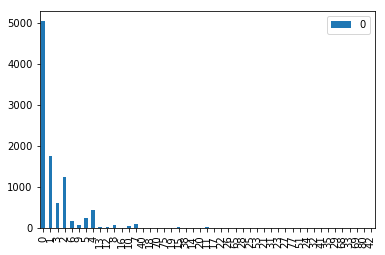

In [78]:
df.plot(kind='bar')

In [28]:
def fit_lsi(train_reviews):
    #Input: train_reviews is a list of reviews that will be used to train the LSI feature transformer
    #Output: A trained LSI model and the transformed training reviews

    texts = [[word for word in review.lower().split() if (word not in stop_words)]
              for review in train_reviews]
    
    dictionary = corpora.Dictionary(texts)

    corpus = [dictionary.doc2bow(text) for text in texts]

    numpy_matrix = matutils.corpus2dense(corpus, num_terms=10000)
    singular_values = np.linalg.svd(numpy_matrix, full_matrices=False, compute_uv=False)
    mean_sv = sum(list[singular_values])/len(singular_values)
    topics = int(mean_sv)

    tfidf = models.TfidfModel(corpus)
    corpus_tfidf = tfidf[corpus]

    lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=topics)

    return lsi, topics, dictionary

In [79]:
texts = [[word for word in review.lower().split() if (word not in stop_words)]
              for review in train_reviews]
    

In [80]:
dictionary = corpora.Dictionary(texts)

In [81]:
corpus = [dictionary.doc2bow(text) for text in texts]

In [83]:
numpy_matrix = matutils.corpus2dense(corpus, num_terms=90000)

In [34]:
singular_values = np.linalg.svd(numpy_matrix, full_matrices=False, compute_uv=False)

In [35]:
singular_values

array([ 8.93147564,  7.67790556,  6.79327393,  5.8468914 ,  5.40789604,
        5.00641727,  4.35379648,  4.00836754,  3.87964082,  3.2496264 ], dtype=float32)

In [39]:
mean_sv =singular_values.sum()/len(singular_values)

In [40]:
topics = int(mean_sv)

In [41]:
tfidf = models.TfidfModel(corpus)

In [42]:
corpus_tfidf = tfidf[corpus]


In [43]:
lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=topics)

In [44]:
topics

5

In [45]:
lsi

In [47]:
dictionary

In [49]:
lsi, topics, dictionary = yml.fit_lsi(train_reviews)


In [51]:
print(dictionary)

Dictionary(214 unique tokens: ['enjoy', 'service', 'someone', 'competent', 'personable,']...)


In [52]:
print(lsi)

LsiModel(num_terms=214, num_topics=5, decay=1.0, chunksize=20000)


In [ ]:
split_samp = .30

In [ ]:
estimator = RandomForestClassifier()

In [ ]:
reviews = []
stars = []
cool = []
useful = []
funny = []
compliment = []
cunumber = []

for key in reviews_json.keys():
    for review in reviews_json[key]:
        reviews.append(review['text'])
        cool.append(review['cool'])
        useful.append(review['useful'])
        funny.append(review['funny'])
        compliment.append(review['funny']+review['useful']+review['cool'])
        cunumber.append(review['useful']+review['cool'])

In [3]:


    
    #Create a training and test sample from the user reviewed restaurants
    
    random_int = random.randint(1, len(business_ids)-1)
    len_random = int(len(business_ids) * split_samp)
    test_set = business_ids[random_int:random_int+len_random]
    training_set = business_ids[0:random_int]+business_ids[random_int+len_random:len(business_ids)]
    train_reviews, train_ratings = [], []

    #Create a list of training reviews and training ratings
    for rest_id in training_set:
        train_reviews.extend(list(user_df[user_df['biz_id'] == rest_id]['review_text']))
        train_ratings.extend(list(user_df[user_df['biz_id'] == rest_id]['rating']))

    #Transform the star labels into a binary class problem, 0 if rating is < 4 else 1
    train_labels = [1 if x >=4 else 0 for x in train_ratings]
    
    #Fit LSI model and return number of LSI topics
    lsi, topics, dictionary = yml.fit_lsi(train_reviews)
    
    #Make a FeatureUnion object with the desired features then fit to train reviews
    comb_features = yml.make_featureunion()
    comb_features.fit(train_reviews)
    
    train_features = comb_features.transform(train_reviews)
    train_lsi = yml.get_lsi_features(train_reviews, lsi, topics, dictionary)
    train_features = sparse.hstack((train_features, train_lsi))
    train_features = train_features.todense()
    
    #fit each model in turn 
    model_runs = [(True, False, False, False, False), (False, True, False, False, False), 
                  (False, False, True, False, False), (False, False, False, True, False),
                 (False, False, False, False, True)]
    test_results = {}
for i in tqdm.tqdm(range(0, len(model_runs))):
clf = yml.fit_model(train_features, train_labels, svm_clf = model_runs[i][0], 
                        RandomForest = model_runs[i][1], nb = model_runs[i][2])
        threshold = 0.7
        error = yml.test_user_set(test_set, clf, restaurant_df, user_df, comb_features, threshold, lsi, topics, dictionary)
        test_results[clf] = error
    break
    #Get top predictions
    for key in test_results.keys():
        results = test_results[test_results.keys()[0]]
        log_loss = yml.get_log_loss()
        print log_loss
        
    break

SyntaxError: Missing parentheses in call to 'print' (<ipython-input-3-82cfb753c6db>, line 63)